<a href="https://colab.research.google.com/github/Maoelan/transformer-imdb/blob/main/transformer_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=25000)

In [3]:
x_train = pad_sequences(x_train, maxlen=200)
x_test = pad_sequences(x_test, maxlen=200)

In [4]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [5]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = models.Sequential([layers.Dense(ff_dim, activation='relu'), layers.Dense(embed_dim)])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=True):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [6]:
vocab_size = 25000
embedding_dim = 64
hidden_dim = 128
output_dim = 1
num_heads = 2
n_layers = 2
dropout_rate = 0.1

In [7]:
inputs = layers.Input(shape=(200,))
embedding_layer = TokenAndPositionEmbedding(200, vocab_size, embedding_dim)
x = embedding_layer(inputs)

In [8]:
for _ in range(n_layers):
    x = TransformerBlock(embedding_dim, num_heads, hidden_dim, dropout_rate)(x)

x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.5)(x)  # Adjust dropout rate as needed
x = layers.Dense(20, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)  # Add L2 regularization
x = layers.Dropout(0.5)(x)  # Adjust dropout rate as needed
outputs = layers.Dense(output_dim, activation="sigmoid")(x)

model = models.Model(inputs=inputs, outputs=outputs)

### Model Transformer

Model Transformer yang diimplementasikan dapat dijelaskan dengan rumus matematika berikut:

**Token and Position Embedding:**

$$
\text{TokenEmbedding}(x) = W_{\text{token}} \cdot x
$$

$$
\text{PositionEmbedding}(x) = W_{\text{position}} \cdot \text{positions}
$$

$$
\text{Embedding}(x) = \text{TokenEmbedding}(x) + \text{PositionEmbedding}(x)
$$

**Transformer Block:**

$$
\text{MultiHeadAttention}(x) = \text{MultiHead}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right) \cdot V
$$

$$
\text{FeedForward}(x) = \text{ReLU}(W_1 \cdot (\text{LayerNorm}(x)) + b_1) \cdot W_2 + b_2
$$

$$
\text{LayerNorm}(x) = \text{LayerNormalization}(x)
$$

$$
\text{TransformerBlock}(x) = \text{LayerNorm}(x + \text{Dropout}(\text{MultiHeadAttention}(x)) + \text{Dropout}(\text{FeedForward}(x))
$$

**Model Output:**

$$
\text{GlobalAveragePooling1D}(x) = \frac{1}{T} \sum_{t=1}^{T} x_t
$$

$$
\text{Dense}(x) = \text{ReLU}(W_1 \cdot x + b_1)
$$

$$
\text{Output}(x) = \text{Sigmoid}(W_2 \cdot x + b_2)
$$

di mana:
- $W_{\text{token}}$, $W_{\text{position}}$, $W_1$, $W_2$ adalah matriks bobot.
- $b_1$, $b_2$ adalah vektor bias.
- $Q$, $K$, $V$ adalah matriks Query, Key, dan Value yang dihasilkan dari $x$.
- $d_k$ adalah dimensi dari $K$.
- $T$ adalah panjang dari urutan (sequence length).
- $\text{Dropout}$ adalah operasi dropout dengan tingkat dropout yang ditentukan.

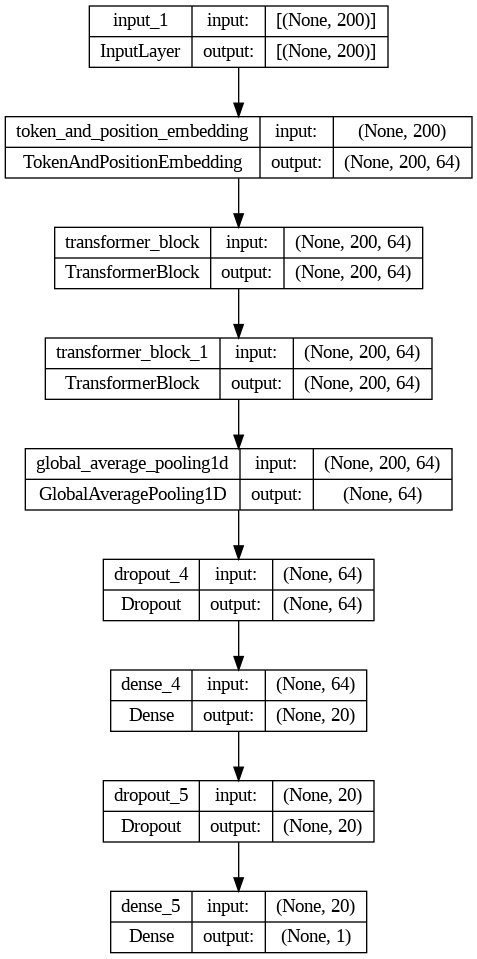

In [9]:
plot_model(model, to_file='transformer_model.png', show_shapes=True, show_layer_names=True)

In [10]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
history = model.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_val, y_val))

Epoch 1/5
313/313 [==============================] - 60s 141ms/step - loss: 0.7959 - accuracy: 0.5879 - val_loss: 0.4215 - val_accuracy: 0.8426
Epoch 2/5
313/313 [==============================] - 27s 87ms/step - loss: 0.3383 - accuracy: 0.8880 - val_loss: 0.3129 - val_accuracy: 0.8848
Epoch 3/5
313/313 [==============================] - 17s 54ms/step - loss: 0.1824 - accuracy: 0.9492 - val_loss: 0.3508 - val_accuracy: 0.8712
Epoch 4/5
313/313 [==============================] - 13s 41ms/step - loss: 0.1095 - accuracy: 0.9726 - val_loss: 0.4451 - val_accuracy: 0.8696
Epoch 5/5
313/313 [==============================] - 11s 34ms/step - loss: 0.0764 - accuracy: 0.9831 - val_loss: 0.5423 - val_accuracy: 0.8626


In [12]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc * 100:.2f}%')

782/782 [==============================] - 6s 8ms/step - loss: 0.6060 - accuracy: 0.8446
Test Loss: 0.606 | Test Acc: 84.46%


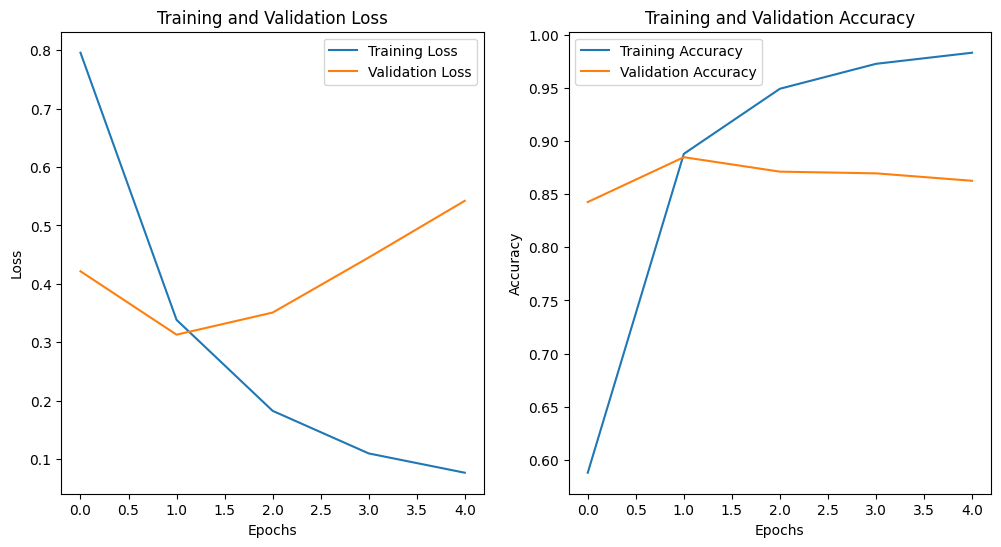

In [13]:
import matplotlib.pyplot as plt

training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [15]:
import numpy as np

reviews_to_test = [
    "This movie is fantastic! I really enjoyed it.",
    "The acting was terrible, and the plot was boring. I would not recommend it."
]

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
texts = [" ".join(map(str, review)) for review in x_train]
tokenizer.fit_on_texts(texts)

sequences_to_test = tokenizer.texts_to_sequences(reviews_to_test)
padded_sequences_to_test = pad_sequences(sequences_to_test, maxlen=200)

predictions = model.predict(padded_sequences_to_test)

for i, review in enumerate(reviews_to_test):
    sentiment = "Positive" if predictions[i][0] > 0.5 else "Negative"
    print(f"Review {i + 1}: {review}")
    print(f"Sentiment Prediction: {predictions[i][0]}")
    print(f"Sentiment: {sentiment}\n")

1/1 [==============================] - 0s 30ms/step
Review 1: This movie is fantastic! I really enjoyed it.
Sentiment Prediction: 0.517648458480835
Sentiment: Positive

Review 2: The acting was terrible, and the plot was boring. I would not recommend it.
Sentiment Prediction: 0.44470247626304626
Sentiment: Negative

